#McCall

##Terminology:

*   **Policy 1:** The benefit is 40% after 52 periods.
*   **Policy 2:** The benfit is 40% after 52 periods, AND an effort floor is implemented
*   **Policy 3:** The benefit is set to 10% after 52 periods, but NO effort floor is implemented




*   **In policy period**: The period from t = 1 .. 52
*   **Steady state period**: The period from t = > 52 (after 52 periods, there are no more new shifs in policies, but the ones already implemented are active)






##Current version:

*   **Probability:** Linear in effort (Handbook version p.9 buttom)
*   **Search costs:** Convex (Handbook version p. 13)
*   **Wage interval:** 0..40
*   **Wage offer distribution:** log-normal (Handbook version p. 13) and calibrated to the data from "BM_dataUSoc" that yields mu= 2.1107 and sigma=0-6784 when scaled to 0..40
*   **Wage:** 90% of median wage (maximum rule of "dagpenge" in Denmark)
*   **Utility:** log (handbook version p.13)
*   **Heterogeneity:** search costs (different parameters but same functional form)






##Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.stats import lognorm

##Parameters

In [ ]:
#Wage distribution parameters for log-normal wage distribution
mu = 2.1107        #Median wage
sigma = 0.6784   #Variance

#Other parameters
beta = 0.999414418  #Weekly discount parameter (3 % yearly)
b = 0.7 * np.exp(mu+(1/2)*sigma) #Monetary value of unemployment
b_cutoff_aggressive = 0.1 * np.exp(mu+(1/2)*sigma)
b_cutoff = 0.4 * np.exp(mu+(1/2)*sigma) #Monetary value of benefit after cutoff
w_min, w_max = 1e-3,40 #Minimum and maximum wage, with 1e-3 to avoid log(0)
num_w = 1000
w_grid = np.linspace(w_min, w_max, num_w) #Array that stores the possible wages as 1000 evenly distributed wages between w_min and w_max
max_iter = 1000

#Costt and probability functions
j = 1         #Level shifter in probability function
gamma = 0.5   #Concavity of probability function

k_high = 10         #level shifter in cost function
kappa_high = 4      #Convexity of cost function (lower kappa --> higher costs)

k_low = 100          #Level shifter cost function
kappa_low = 4       #Convexity of low type cost function (lower kappa --> higher costs)

#Time dependency
T=104
UI_duration=(T/2)

#Minimum effort values
e_min_base = 0.0    #Just a base
e_min_floor = 0.5842  #The actual search effort floor implemented by the policy

##Auxiliary functions

In [ ]:
#Value of employemt
def W(w,beta):    #The value of employment is given as the wage, w, discounted for eternity to today
  return np.log(w) / (1 - beta)

#Wage distribution (uniform)
#def f(w):
#  return 1 / (w_max - w_min) if w_min <= w <= w_max else 0 #density function given uniform wage distribution
#f_values = np.array([f(w) for w in w_grid])                    #Collects the individual probability of each wage offer. Ofc 0.05 for each, as we have 50 gridpoints and the wage is uniformly distributed.

#Wage distribution (log-normal)
def f(w):
  return lognorm.pdf(w, sigma, scale=np.exp(mu))                 # log-normal PDF with std. dev. sigma and median wage exp(mu)
f_values = f(w_grid)
f_values = f_values / np.trapezoid(f_values, w_grid)             #Normalize the probabilities such that they integrate to 1 over the wage grid. This is to adress potential underestimating of the probability of tail-values of the wage distribution, as this is cut off at a certain ponit (for now, 40)

#Probability (sigmoid form)
#def p_e(j, e, gamma):
  #return 1 / (1 + np.exp(-j * (e - gamma)))


#Probability of job offer (Handbook-form)
"""
Probability is linear in effort. With j=1, the probability is equal to the effort

"""
def p_e(j, e, gamma):
  #Linear form (Handbook-form (1:1 with j=1))
  if 0 <= j * e <=1:
    return j*e
  if j*e < 0:
    return 0
  if j*e > 1:
    return 1

#Cost of applying effort (Handbook-form p. 13 in PDF). NOTE that higher kappa means lower costs.

def c_e_high(k_high, e, kappa_high):                              #high type costs
  return k_high * ((e ** (1+kappa_high))/(1+kappa_high))

def c_e_low(k_low, e, kappa_low):                                 #low type costs
  return k_low * ((e ** (1+kappa_low))/(1+kappa_low))

#Benefit path
def b_t(t):                                                       #Benefit is b for t=0..UI-duration and b/2 for t=UI-duration..T and onwards.
  return b if t <= UI_duration else b_cutoff                      #I use general terms so i can easily change the scheme in the parameters section

def b_t_aggressive(t):
    return b if t <= UI_duration else b_cutoff_aggressive

#Exit probability: probability of exiting unemployment at time t
"""
Define exit function that takes effort, reservation wage, probability scale,
gamma (only relevant if using sigmoid prob), sigma (log normal variance) and
mu (underlying mean/median of normal distribution) as inputs.

The function finds the probability of a job offer p_offer, and the chance of
the wage being above the reservatino wage, and hence accept worthy, p_accept.
The exit probability is then the product of these two.
"""
def exit_probability(e, w_star, j, gamma, sigma, mu):
    p_offer = p_e(j, e, gamma)                                    #Probability of job offer
    p_accept = 1 - lognorm.cdf(w_star, s=sigma, scale=np.exp(mu)) #Probability of accepting
    return p_offer * p_accept                                     #Exit probability



##Value of unemployment, reservation wage and optimal search effot at terminal period and in policy-period

In [ ]:
#Note the terminology "Terminal period": t>=T and "policy-period": t<T

#Steady state value of unemployment (used for the terminal period)

def steady_state_U(b_cutoff, beta, j, gamma, k, kappa, w_grid, f_values, worker_type, e_min, b_func=b_t):
  """
Idea:
This function calculates the steady state value, which is used as the terminal period
value t=T+1, from which t=T, t=T-1 etc. are calculated. That is, the agent anticipate,
that after the period with policies, they arive at a steady state.

Mechanics:
The worker looks at all the possible job offers (that vary in wage), and hold them
up to benefit they can get from unemployment. If the unemployment
value is highest, they choose to stay unemployed. This creates a vector of values
based on the optimal choice comparing each possible offer to unemployment.
With all the optimal decisions in place, they can find the expected value of unemployment
based on the probabilites of the different job offers. This gives the opportunity to
calculate the reservation wage, which is the minimum wage required for the individual to
take the job vs staying unemployed.

Optimal search effort:
Furhter, the agent can choose a level of costly search effort, that affects
the probability of getting a job offer. Each time the value of unemployment
is calculated the agent finds the effort that maximized this.


"""

  #Define cost function dependent on type input:
  #I make it possible to set my workertype when calling the function by typing worker_type=''
  if worker_type == 'high':
    c_e = c_e_high
  elif worker_type == 'low':
    c_e = c_e_low

  U_guess = np.log(b_cutoff) / (1 - beta)         #Starting value / guess for U. Only used as a start for the loop.

  #Run the loop:
  for it in range(max_iter):
    V_w = np.maximum(W(w_grid, beta), U_guess)    #Compares each possible wage to the unemployment value, and choose the maximum of these
    EV = np.trapezoid(V_w * f_values, w_grid)     #Find expected value based on the probability of each wage offer happening

    def objective(e):
      b_val = b_func(T)
      U_e = np.log(b_val) - c_e(k, e, kappa) + beta * (p_e(j, e, gamma) * EV + (1 - p_e(j, e, gamma)) * U_guess) #Calculate value of unemployment
      return -U_e

    result = minimize_scalar(objective, bounds=(e_min, 1), method='bounded')  #use minimize scalar from scipy to find the effort level that max U_e.
    new_U = -result.fun                                                   #As minimize scalar minimize instead of maximize, i flip the values.

    if np.abs(new_U - U_guess) < 1e-6:    #Stopping criteria for the loop. Stop if the new optimal value of unemployment is very close to the previous found.
      break
    U_guess = new_U                       #If the new value is different from the last one, save it as the new optimal.

  return new_U, result.x                  #After all the looping, the function returns the newest, optimal U and the optimal effort that gives this U.

#Value of unemployment for each t in the policy-period

def policy_period(U_terminal, beta, j, gamma, k, kappa, T, UI_duration, w_grid, f_values, worker_type, e_min, b_func=b_t):

  """
Idea:
Same logic as the steady state function, but this is now done for each period in time. That is,
the agent is now forward looking in his decisions, and decides whether to stay unemployed
or take a possible job offer based on its value today but also the discounted, expected values
of the future.

Mechanings:
The value of Unemployment, optimal search effort and reservation wage are tracked and stored
in each period to allow for plotting. The unemployment value is store 1 period forward, as
the optimal effort and reservation wage are determined by the value of unemployment tomorrow.

"""
  #Define cost function dependent on type input:
  if worker_type == 'high':
    c_e = c_e_high
  elif worker_type == 'low':
    c_e = c_e_low

  U_path = np.zeros(T+2)    #Vector for storing the value of unemployment at each time, t
  e_path = np.zeros(T+1)      #Vector for storing the optimal search effort at each time, t
  b_path = np.zeros(T+1)      #Vector for storing the benefit at each time, t

  U_path[T+1] = U_terminal    #Set the terminal value of t=T to the steady state value of unemployment. We don't need to impose e_ss, as this is calculated from U_ss anyways.

  for t in reversed(range(T+1)):
    V_w = np.maximum(W(w_grid, beta), U_path[t+1]) # For each wage choose to take it forever or go unemployed for another week with value U_t+1
    EV = np.trapezoid(V_w * f_values, w_grid)      # Expected value of a wage offer where future, possible wages and unemployment values are takin into account from V_w

    def objective(e):                              # We define a function to choose e, and set the argument to optimize over as search effort, e
      b_val = b_func(t)
      U_e = np.log(b_val) - c_e(k, e, kappa) + beta * (p_e(j, e, gamma) * EV + (1 - p_e(j, e, gamma)) * U_path[t+1]) #Bellman equation

      return -U_e                                  # we want to maximize U_e, so we minimize -U_e

    #Use bounded scalar minimization in [0,1]
    result = minimize_scalar(objective, bounds=(e_min,1), method='bounded') #calculate the optimal e in the bound 0,1
    best_e = result.x                                                   #Extract the optimal search effort from the optimizer
    best_U = -result.fun                                                #recover the value of unemployment at this given effort, e.

    U_path[t] = best_U                             #Store the best_U found such that we can plot the path of U
    e_path[t] = best_e                             #Store the best_e found such that we can plot the path of e
    b_path[t] = b_func(t)                             #Store the benefit path such that we can plot the path of b

  w_star_path = np.exp((1 - beta) * U_path)
  return U_path, e_path, b_path, w_star_path

##Run the functions for high and low type with and without effort floor

In [ ]:

#Run / call the steady state and the policy-period function defined above:

#######################
#No search effort floor
#######################
# First for high type

U_ss_high, e_ss_high = steady_state_U(
  b_cutoff, beta, j, gamma, k_high, kappa_high, w_grid, f_values, worker_type='high', e_min=e_min_base)

U_path_high, e_path_high, b_path_high, w_star_path_high = policy_period(
U_terminal=U_ss_high, beta=beta, j=j, gamma=gamma,
    k=k_high, kappa=kappa_high, T=T, UI_duration=UI_duration,
  w_grid=w_grid, f_values=f_values, worker_type='high', e_min=e_min_base)

# Then for low type
U_ss_low, e_ss_low = steady_state_U(
  b_cutoff, beta, j, gamma, k_low, kappa_low, w_grid, f_values, worker_type='low', e_min=e_min_base)

U_path_low, e_path_low, b_path_low, w_star_path_low = policy_period(
  U_terminal=U_ss_low, beta=beta, j=j, gamma=gamma,
  k=k_low, kappa=kappa_low, T=T, UI_duration=UI_duration,
  w_grid=w_grid, f_values=f_values, worker_type='low', e_min=e_min_base)

#Hazard path
"""
I call the exit function that is defined above. This calculates the probability
of exitting unemployment at each time t.
"""
exit_prob_high = np.array([exit_probability(e, w_star, j, gamma, sigma, mu) for e, w_star in zip(e_path_high, w_star_path_high)])
exit_prob_low = np.array([exit_probability(e, w_star, j, gamma, sigma, mu) for e, w_star in zip(e_path_low, w_star_path_low)])


#Survival path
"""
The survival function is the cumulative product of (1 - exit probability)
at each t. This gives the probability of still being unemployed at each time t.

"""
survival_high = np.cumprod(1 - exit_prob_high) #high type hazard
survival_low = np.cumprod(1 - exit_prob_low)   #low type hazard


########################
# Search effort floor
########################

"""
Same as above but with the floor implemented. I run the seperatly to enable a plotting comparison.
"""

# High type
U_ss_high_floor, e_ss_high_floor = steady_state_U(
  b_cutoff, beta, j, gamma, k_high, kappa_high, w_grid, f_values,
  worker_type='high', e_min=e_min_floor)

U_path_high_floor, e_path_high_floor, b_path_high_floor, w_star_path_high_floor = policy_period(
  U_terminal=U_ss_high_floor, beta=beta, j=j, gamma=gamma,
  k=k_high, kappa=kappa_high, T=T, UI_duration=UI_duration,
  w_grid=w_grid, f_values=f_values, worker_type='high', e_min=e_min_floor)

# Low type
U_ss_low_floor, e_ss_low_floor = steady_state_U(
  b_cutoff, beta, j, gamma, k_low, kappa_low, w_grid, f_values,
  worker_type='low', e_min=e_min_floor)

U_path_low_floor, e_path_low_floor, b_path_low_floor, w_star_path_low_floor = policy_period(
  U_terminal=U_ss_low_floor, beta=beta, j=j, gamma=gamma,
  k=k_low, kappa=kappa_low, T=T, UI_duration=UI_duration,
  w_grid=w_grid, f_values=f_values, worker_type='low', e_min=e_min_floor)

# Hazard path
exit_prob_high_floor = np.array([
  exit_probability(e, w_star, j, gamma, sigma, mu)
  for e, w_star in zip(e_path_high_floor, w_star_path_high_floor)
])
exit_prob_low_floor = np.array([
  exit_probability(e, w_star, j, gamma, sigma, mu)
  for e, w_star in zip(e_path_low_floor, w_star_path_low_floor)
])

# Survival path
survival_high_floor = np.cumprod(1 - exit_prob_high_floor)
survival_low_floor = np.cumprod(1 - exit_prob_low_floor)

########################
# Agressive benefit cut
########################

"""
Policy of an aggresive cut in the benefit
"""

# First for high type

U_ss_high_agg, e_ss_high_agg = steady_state_U(
  b_cutoff, beta, j, gamma, k_high, kappa_high, w_grid, f_values, worker_type='high', e_min=e_min_base, b_func=b_t_aggressive)

U_path_high_agg, e_path_high_agg, b_path_high_agg, w_star_path_high_agg = policy_period(
U_terminal=U_ss_high_agg, beta=beta, j=j, gamma=gamma,
    k=k_high, kappa=kappa_high, T=T, UI_duration=UI_duration,
  w_grid=w_grid, f_values=f_values, worker_type='high', e_min=e_min_base, b_func=b_t_aggressive)

# Then for low type
U_ss_low_agg, e_ss_low_agg = steady_state_U(
  b_cutoff, beta, j, gamma, k_low, kappa_low, w_grid, f_values, worker_type='low', e_min=e_min_base, b_func=b_t_aggressive)

U_path_low_agg, e_path_low_agg, b_path_low_agg, w_star_path_low_agg = policy_period(
  U_terminal=U_ss_low_agg, beta=beta, j=j, gamma=gamma,
  k=k_low, kappa=kappa_low, T=T, UI_duration=UI_duration,
  w_grid=w_grid, f_values=f_values, worker_type='low', e_min=e_min_base, b_func=b_t_aggressive)

#Hazard path
"""
I call the exit function that is defined above. This calculates the probability
of exitting unemployment at each time t.
"""
exit_prob_high_agg = np.array([exit_probability(e, w_star, j, gamma, sigma, mu) for e, w_star in zip(e_path_high_agg, w_star_path_high_agg)])
exit_prob_low_agg = np.array([exit_probability(e, w_star, j, gamma, sigma, mu) for e, w_star in zip(e_path_low_agg, w_star_path_low_agg)])


#Survival path
"""
The survival function is the cumulative product of (1 - exit probability)
at each t. This gives the probability of still being unemployed at each time t.

"""
survival_high_agg = np.cumprod(1 - exit_prob_high_agg) #high type hazard
survival_low_agg = np.cumprod(1 - exit_prob_low_agg)   #low type hazard

##Calibration

In [ ]:
"""
This block calculates the excact minimal effort floor required to equalize
the value of the survival function of policy 1 and 2 at t=104. The value
should then be plotted back in e_min parameters at the parameters section

"""

# Step 1: Compute reference survival under Policy 3 (aggressive cut)
U_ss_agg, _ = steady_state_U(
    b_cutoff_aggressive, beta, j, gamma, k_low, kappa_low, w_grid, f_values,
    worker_type='low', e_min=0.0, b_func=b_t_aggressive
)
U_path_agg, e_path_agg, _, w_star_path_agg = policy_period(
  U_terminal=U_ss_agg, beta=beta, j=j, gamma=gamma,
  k=k_low, kappa=kappa_low, T=T, UI_duration=UI_duration,
  w_grid=w_grid, f_values=f_values, worker_type='low', e_min=0.0,
  b_func=b_t_aggressive)

exit_prob_agg = np.array([
  exit_probability(e, w_star, j, gamma, sigma, mu)
  for e, w_star in zip(e_path_agg, w_star_path_agg)])

survival_low_agg = np.cumprod(1 - exit_prob_agg)

# Step 2: Loss function matching final survival probability
def loss_e_min_survival(e_min_candidate):
  U_ss, _ = steady_state_U(
    b_cutoff, beta, j, gamma, k_low, kappa_low, w_grid, f_values,
    worker_type='low', e_min=e_min_candidate, b_func=b_t)

  U_path, e_path, _, w_star_path = policy_period(
    U_terminal=U_ss, beta=beta, j=j, gamma=gamma,
    k=k_low, kappa=kappa_low, T=T, UI_duration=UI_duration,
    w_grid=w_grid, f_values=f_values, worker_type='low', e_min=e_min_candidate,
    b_func=b_t)
  exit_prob = np.array([
    exit_probability(e, w_star, j, gamma, sigma, mu)
    for e, w_star in zip(e_path, w_star_path)])
  survival = np.cumprod(1 - exit_prob)

  return (survival[-1] - survival_low_agg[-1])**2

# Step 3: Calibrate e_min
res = minimize_scalar(loss_e_min_survival, bounds=(0.0, 1.0), method='bounded')
optimal_e_min = res.x
print(f"Optimal e_min to match 2-year survival under Policy 3: {optimal_e_min:.4f}")


Optimal e_min to match 2-year survival under Policy 3: 0.5842


##Policy 1 plots

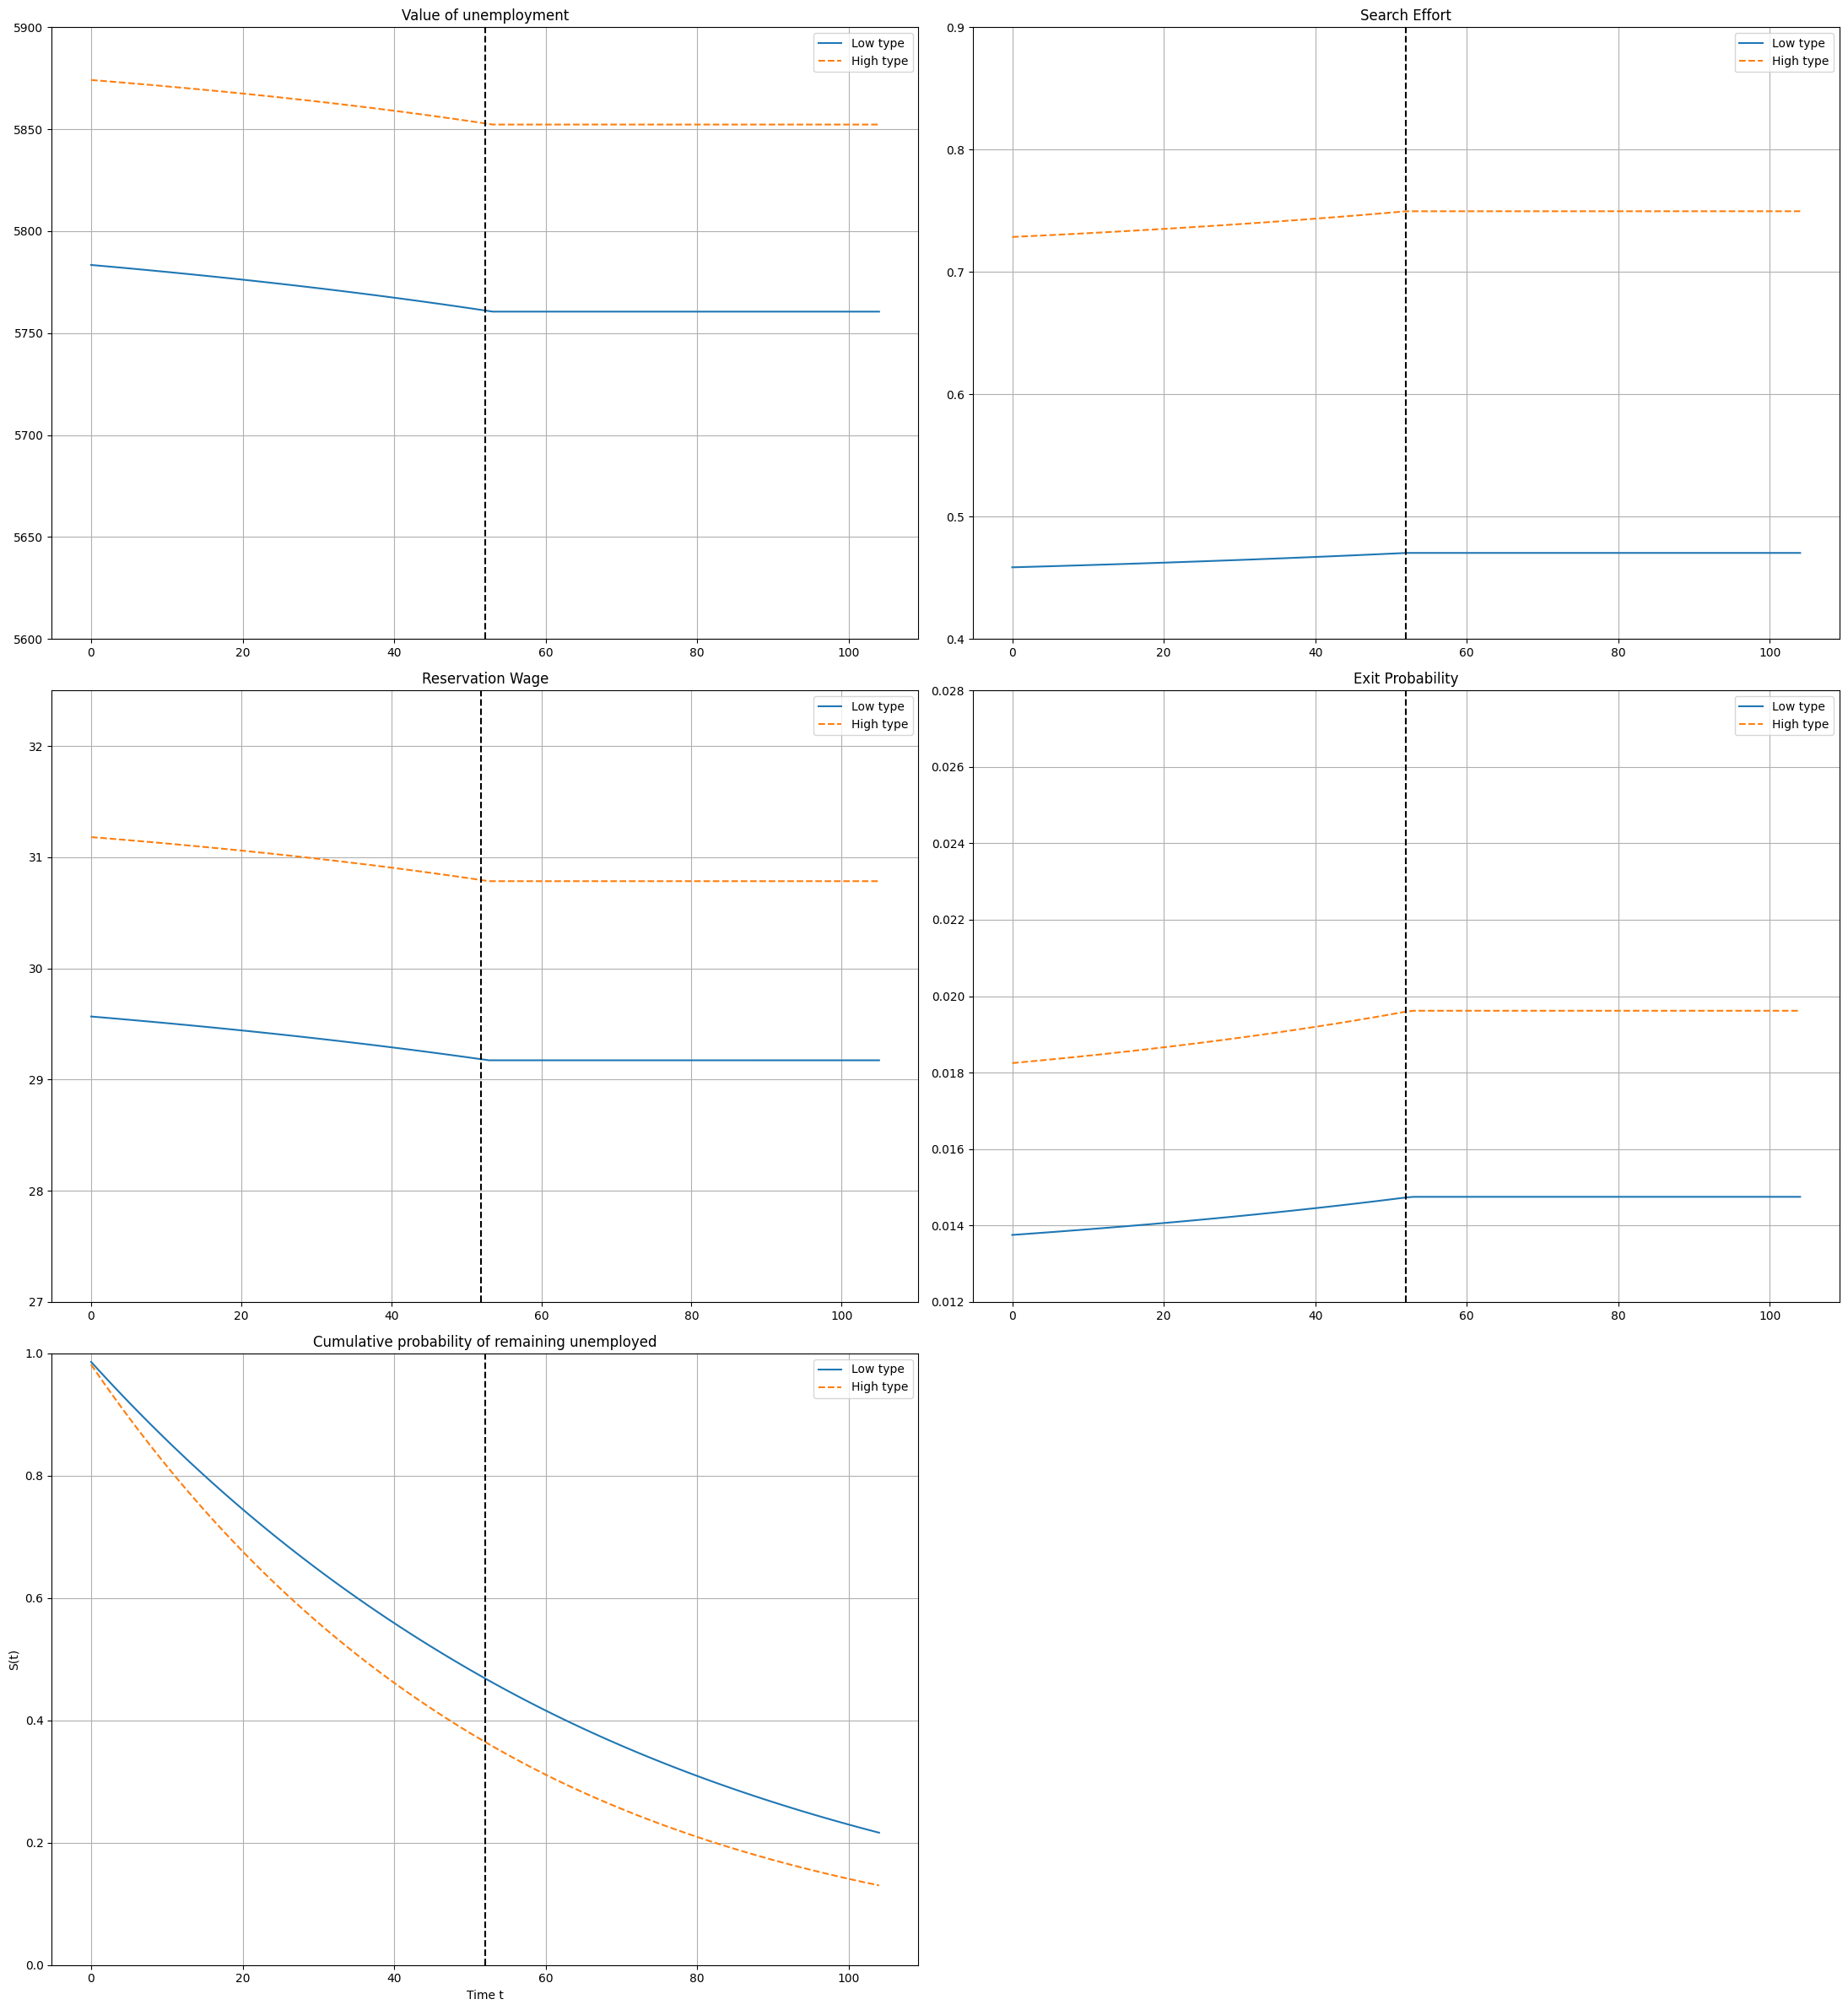

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(22, 26))

ylim_settings = {
    0: (5600, 5900),    # U(t)
    1: (0.4, 0.9),      # e(t)
    2: (27, 32.5),      # w*(t)
    3: (0.012, 0.028),  # exit prob
    4: (0, 1.0)         # survival
}

# Row 1: U(t) and Search Effort
axs[0, 0].plot(U_path_low[:-1], label="Low type")
axs[0, 0].plot(U_path_high[:-1], linestyle='--', label="High type")
axs[0, 0].set_title("Value of unemployment")
axs[0, 0].set_ylim(ylim_settings[0])
axs[0, 0].axvline(UI_duration, linestyle='--', color='black')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(e_path_low, label="Low type")
axs[0, 1].plot(e_path_high, linestyle='--', label="High type")
axs[0, 1].set_title("Search Effort")
axs[0, 1].set_ylim(ylim_settings[1])
axs[0, 1].axvline(UI_duration, linestyle='--', color='black')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Row 2: Reservation Wage and Exit Probability
axs[1, 0].plot(w_star_path_low, label="Low type")
axs[1, 0].plot(w_star_path_high, linestyle='--', label="High type")
axs[1, 0].set_title("Reservation Wage")
axs[1, 0].set_ylim(ylim_settings[2])
axs[1, 0].axvline(UI_duration, linestyle='--', color='black')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(exit_prob_low, label="Low type")
axs[1, 1].plot(exit_prob_high, linestyle='--', label="High type")
axs[1, 1].set_title("Exit Probability")
axs[1, 1].set_ylim(ylim_settings[3])
axs[1, 1].axvline(UI_duration, linestyle='--', color='black')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Row 3: Survival Function in left only
axs[2, 0].plot(survival_low, label="Low type")
axs[2, 0].plot(survival_high, linestyle='--', label="High type")
axs[2, 0].set_title("Cumulative probability of remaining unemployed")
axs[2, 0].set_ylim(ylim_settings[4])
axs[2, 0].set_xlabel("Time t")
axs[2, 0].set_ylabel("S(t)")
axs[2, 0].axvline(UI_duration, linestyle='--', color='black')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Empty the right cell in row 3
axs[2, 1].axis("off")

# Finalize
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("policy1outcommes", dpi=300)
plt.show()


## Policy 1, 2 and 3 plots side by side with uniform axis' to make comparison easy

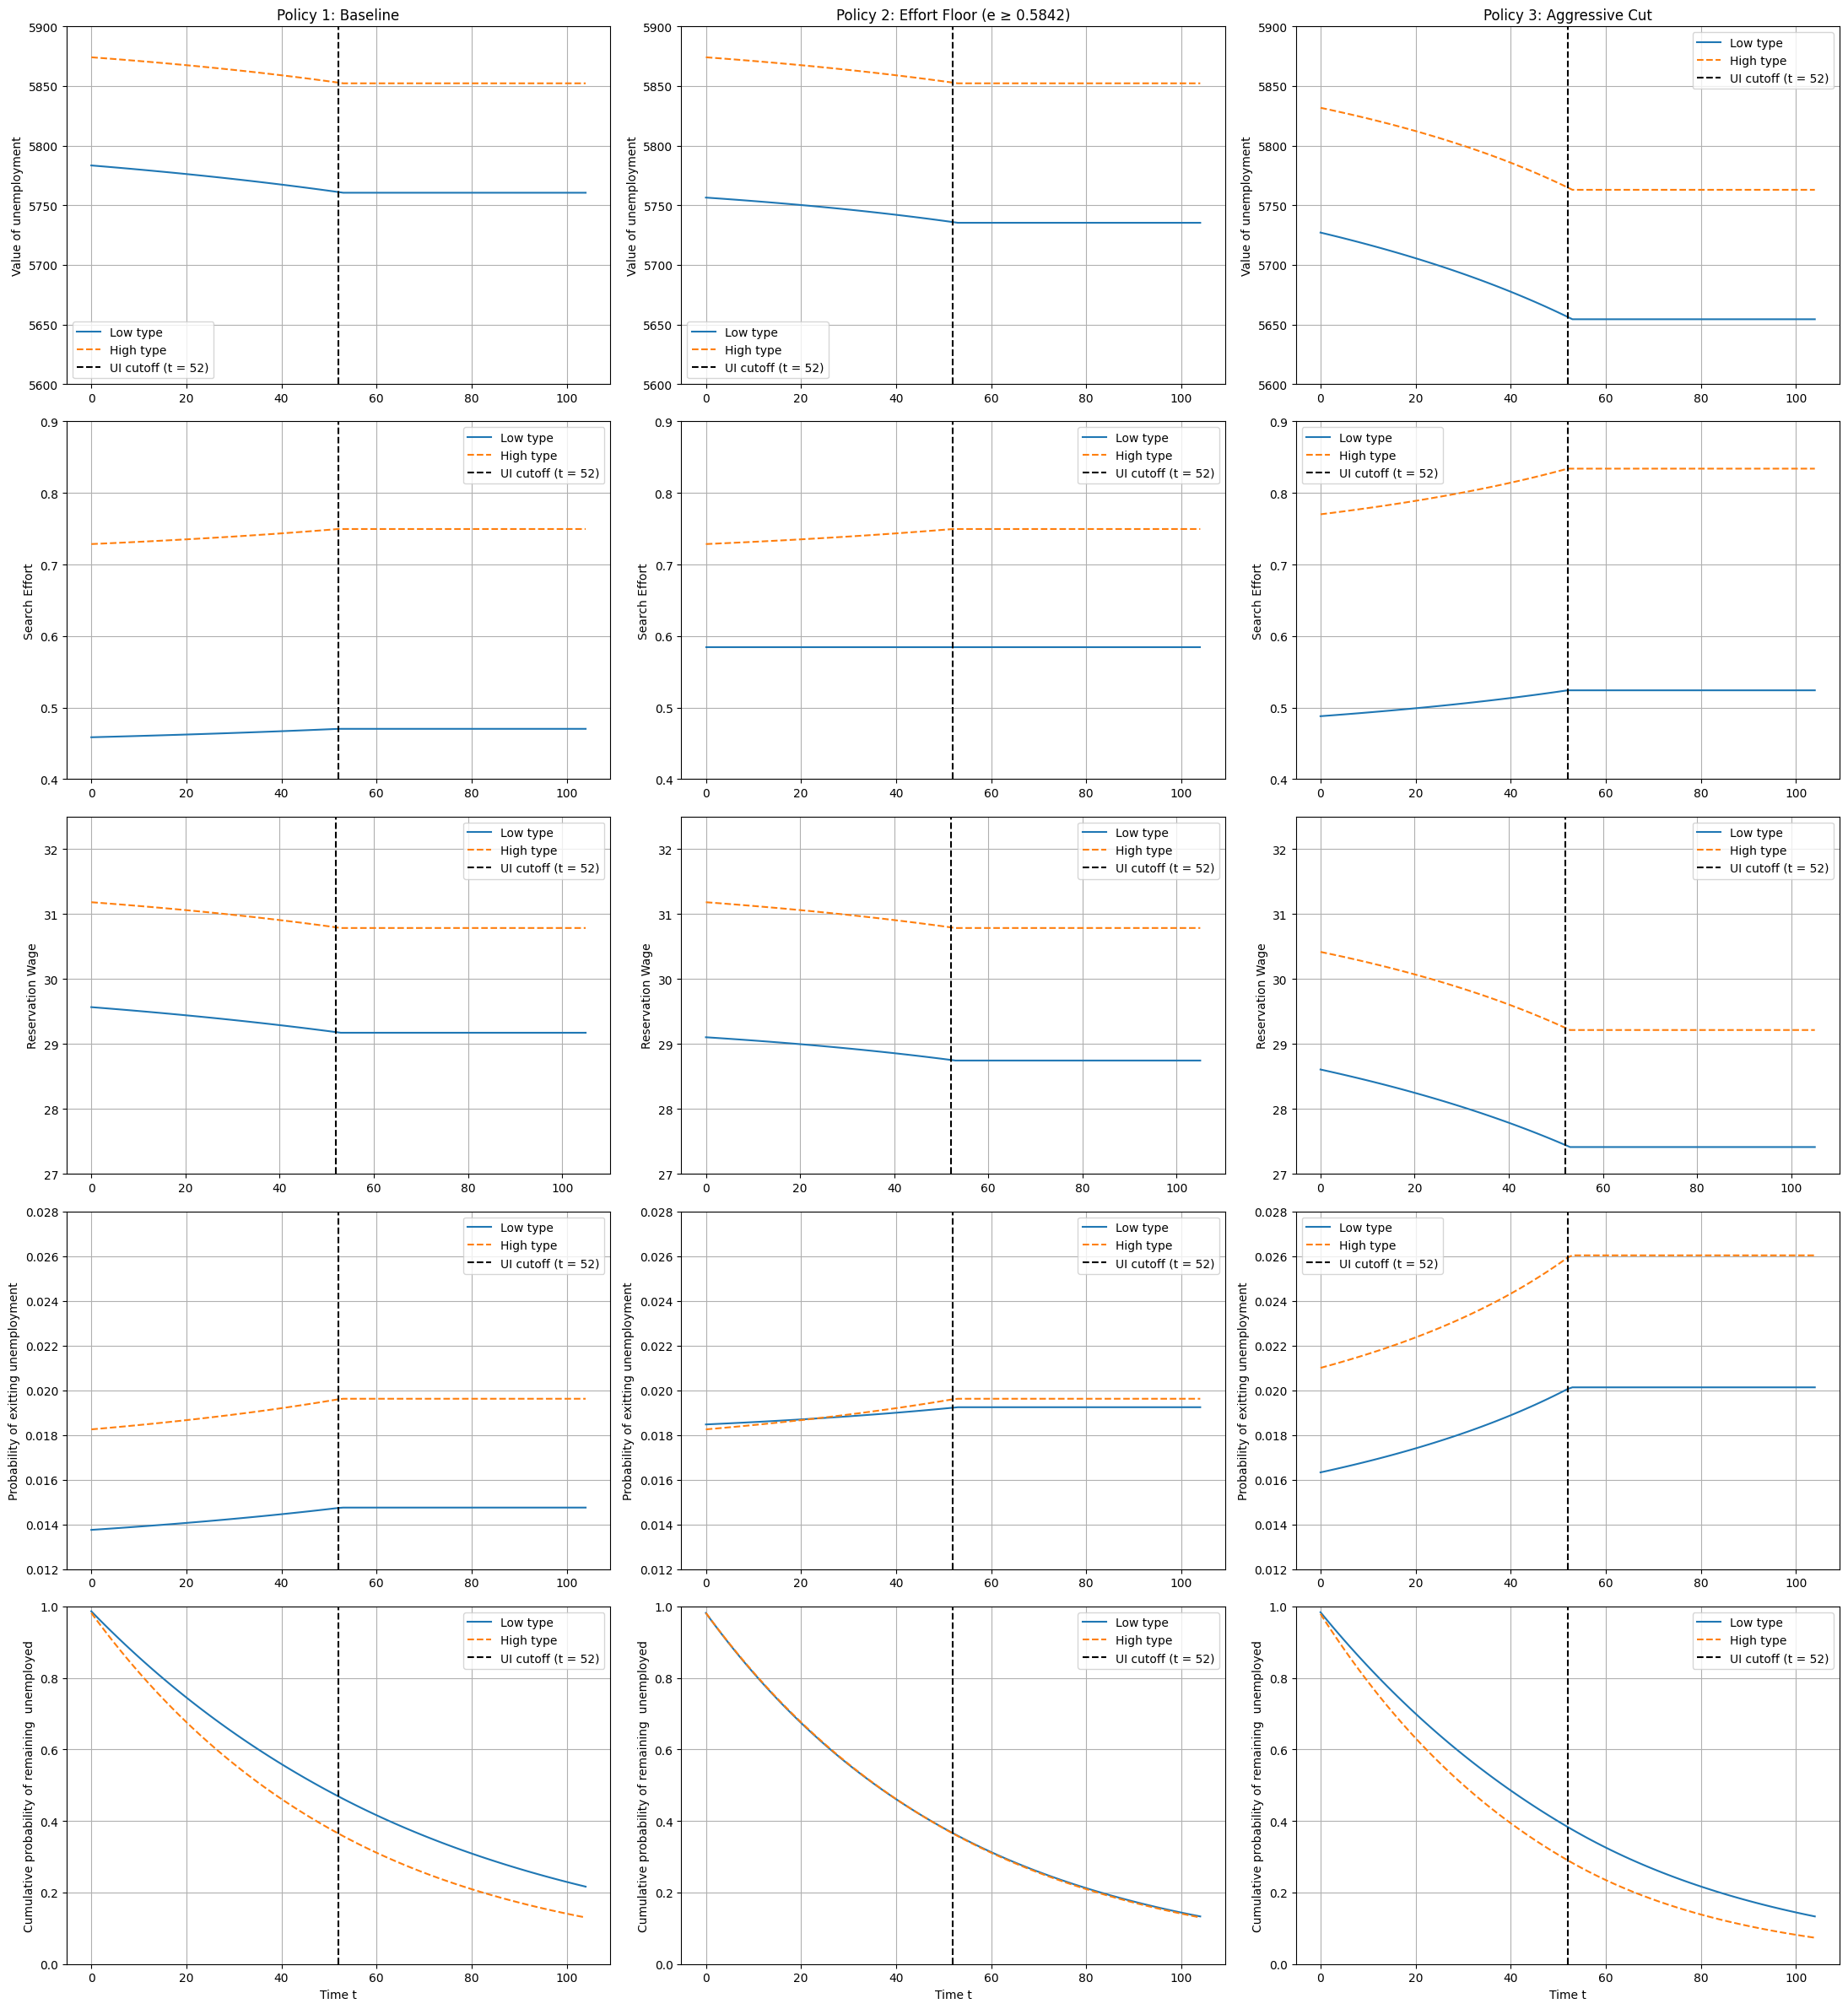

Survival at t=102 under Policy 2 (floor):      0.138456
Survival at t=102 under Policy 3 (aggressive): 0.138684
Survival at t=102 under Policy 2 (floor):      0.135454
Survival at t=102 under Policy 3 (aggressive): 0.077593


In [ ]:
fig, axs = plt.subplots(5, 3, figsize=(22, 26))
titles = [
    "Value of unemployment", "Search Effort", "Reservation Wage",
    "Probability of exitting unemployment", "Cumulative probability of remaining  unemployed"
]
policy_titles = [
    "Policy 1: Baseline",
    f"Policy 2: Effort Floor (e ≥ {e_min_floor})",
    f"Policy 3: Aggressive Cut"
]

ylim_settings = {
    0: (5600, 5900),
    1: (0.4, 0.9),
    2: (27, 32.5),
    3: (0.012, 0.028),
    4: (0, 1.0)
}

# Row 1
axs[0, 0].plot(U_path_low[:-1], label="Low type")
axs[0, 0].plot(U_path_high[:-1], linestyle='--', label="High type")
axs[0, 0].set_title(policy_titles[0])
axs[0, 0].set_ylabel(titles[0])
axs[0, 0].grid(True)

axs[0, 1].plot(U_path_low_floor[:-1], label="Low type")
axs[0, 1].plot(U_path_high_floor[:-1], linestyle='--', label="High type")
axs[0, 1].set_title(policy_titles[1])
axs[0, 1].set_ylabel(titles[0])
axs[0, 1].grid(True)

axs[0, 2].plot(U_path_low_agg[:-1], label="Low type")
axs[0, 2].plot(U_path_high_agg[:-1], linestyle='--', label="High type")
axs[0, 2].set_title(policy_titles[2])
axs[0, 2].set_ylabel(titles[0])
axs[0, 2].grid(True)

# Row 2
axs[1, 0].plot(e_path_low, label="Low type")
axs[1, 0].plot(e_path_high, linestyle='--', label="High type")
axs[1, 0].set_ylabel(titles[1])
axs[1, 0].grid(True)

axs[1, 1].plot(e_path_low_floor, label="Low type")
axs[1, 1].plot(e_path_high_floor, linestyle='--', label="High type")
axs[1, 1].set_ylabel(titles[1])
axs[1, 1].grid(True)

axs[1, 2].plot(e_path_low_agg, label="Low type")
axs[1, 2].plot(e_path_high_agg, linestyle='--', label="High type")
axs[1, 2].set_ylabel(titles[1])
axs[1, 2].grid(True)

# Row 3
axs[2, 0].plot(w_star_path_low, label="Low type")
axs[2, 0].plot(w_star_path_high, linestyle='--', label="High type")
axs[2, 0].set_ylabel(titles[2])
axs[2, 0].grid(True)

axs[2, 1].plot(w_star_path_low_floor, label="Low type")
axs[2, 1].plot(w_star_path_high_floor, linestyle='--', label="High type")
axs[2, 1].set_ylabel(titles[2])
axs[2, 1].grid(True)

axs[2, 2].plot(w_star_path_low_agg, label="Low type")
axs[2, 2].plot(w_star_path_high_agg, linestyle='--', label="High type")
axs[2, 2].set_ylabel(titles[2])
axs[2, 2].grid(True)

# Row 4
axs[3, 0].plot(exit_prob_low, label="Low type")
axs[3, 0].plot(exit_prob_high, linestyle='--', label="High type")
axs[3, 0].set_ylabel(titles[3])
axs[3, 0].grid(True)

axs[3, 1].plot(exit_prob_low_floor, label="Low type")
axs[3, 1].plot(exit_prob_high_floor, linestyle='--', label="High type")
axs[3, 1].set_ylabel(titles[3])
axs[3, 1].grid(True)

axs[3, 2].plot(exit_prob_low_agg, label="Low type")
axs[3, 2].plot(exit_prob_high_agg, linestyle='--', label="High type")
axs[3, 2].set_ylabel(titles[3])
axs[3, 2].grid(True)

# Row 5
axs[4, 0].plot(survival_low, label="Low type")
axs[4, 0].plot(survival_high, linestyle='--', label="High type")
axs[4, 0].set_ylabel(titles[4])
axs[4, 0].set_xlabel("Time t")
axs[4, 0].grid(True)

axs[4, 1].plot(survival_low_floor, label="Low type")
axs[4, 1].plot(survival_high_floor, linestyle='--', label="High type")
axs[4, 1].set_ylabel(titles[4])
axs[4, 1].set_xlabel("Time t")
axs[4, 1].grid(True)

axs[4, 2].plot(survival_low_agg, label="Low type")
axs[4, 2].plot(survival_high_agg, linestyle='--', label="High type")
axs[4, 2].set_ylabel(titles[4])
axs[4, 2].set_xlabel("Time t")
axs[4, 2].grid(True)

# Add vertical cutoff lines and collect one for legend
cutoff_line = None
for row in axs:
    for ax in row:
        line = ax.axvline(UI_duration, linestyle='--', color='black', linewidth=1.5)
        if cutoff_line is None:
            cutoff_line = line

# Add legend including cutoff
for row in axs:
    for ax in row:
        handles, labels = ax.get_legend_handles_labels()
        if cutoff_line not in handles:
            handles.append(cutoff_line)
            labels.append(f"UI cutoff (t = {int(UI_duration)})")
            ax.legend(handles, labels)

# Apply y-axis limits
for row_idx in range(5):
    for col_idx in range(3):
        axs[row_idx, col_idx].set_ylim(ylim_settings[row_idx])
        axs[row_idx, col_idx].tick_params(labelbottom=True, labelleft=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("policy_comparison_3cols_uniform_axes.png", dpi=300, bbox_inches='tight')
plt.show()


# Compare survival probabilities at t = 102
print(f"Survival low type at t=102 under Policy 2 (floor):      {survival_low_floor[102]:.6f}")
print(f"Survival low type at t=102 under Policy 3 (aggressive): {survival_low_agg[102]:.6f}")

print(f"Survival high type at t=102 under Policy 2 (floor):      {survival_high_floor[102]:.6f}")
print(f"Survival high type at t=102 under Policy 3 (aggressive): {survival_high_agg[102]:.6f}")


## Wage distribution plot

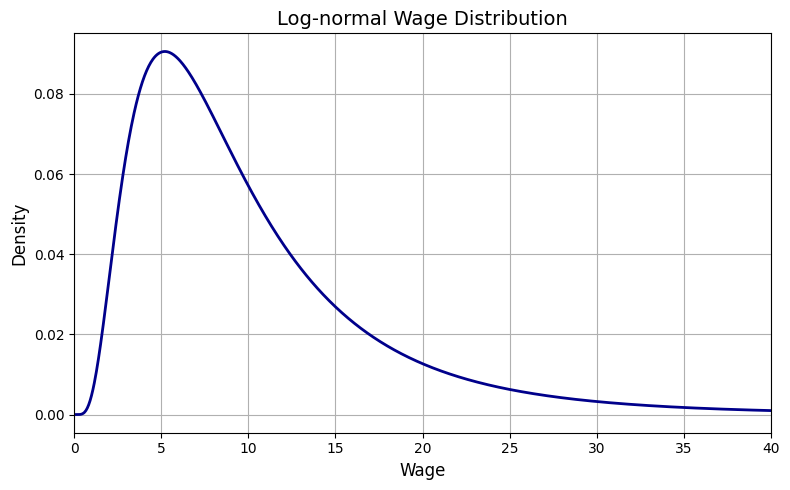

In [ ]:
# Plot: Wage Distribution
plt.figure(figsize=(8, 5))
plt.plot(w_grid, f_values, color='darkblue', lw=2)
plt.title("Log-normal Wage Distribution", fontsize=14)
plt.xlabel("Wage", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True)
plt.xlim(0, 40)
plt.tight_layout()
plt.savefig("wage_distribution.png", dpi=300)
plt.show()


##Cost functions plot

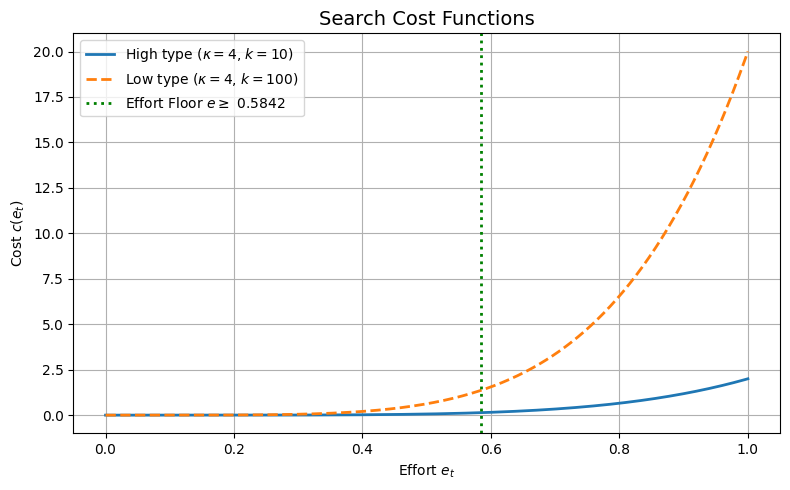

In [ ]:
# Plot: Cost functions for high and low types
e_vals = np.linspace(0, 1, 500)
c_high = c_e_high(k_high, e_vals, kappa_high)
c_low = c_e_low(k_low, e_vals, kappa_low)

plt.figure(figsize=(8, 5))
plt.plot(e_vals, c_high, label="High type ($\\kappa=4$, $k=10$)", linewidth=2)
plt.plot(e_vals, c_low, label="Low type ($\\kappa=4$, $k=100$)", linestyle='--', linewidth=2)
plt.axvline(e_min_floor, color='green', linestyle=':', label=f"Effort Floor $e \\geq$ {e_min_floor}", linewidth=2)
plt.title("Search Cost Functions", fontsize=14)
plt.xlabel("Effort $e_t$")
plt.ylabel("Cost $c(e_t)$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("search_cost_curves.png", dpi=300)
plt.show()


##Benefit path plot

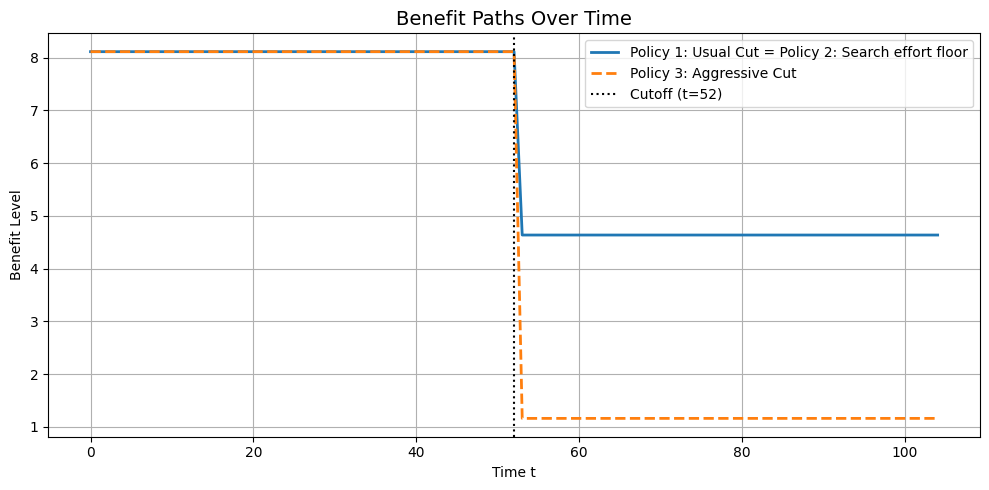

In [ ]:
# Plot: Benefit paths for Policy 1 (usual cut) vs Policy 3 (aggressive cut)
plt.figure(figsize=(10, 5))
plt.plot(b_path_high, label="Policy 1: Usual Cut = Policy 2: Search effort floor", linewidth=2)
plt.plot(b_path_high_agg, label="Policy 3: Aggressive Cut", linestyle='--', linewidth=2)
plt.axvline(UI_duration, color='black', linestyle=':', label=f"Cutoff (t={int(UI_duration)})")
plt.title("Benefit Paths Over Time", fontsize=14)
plt.xlabel("Time t")
plt.ylabel("Benefit Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("benefit_path_comparison.png", dpi=300)
plt.show()


##Bellman plots comparison


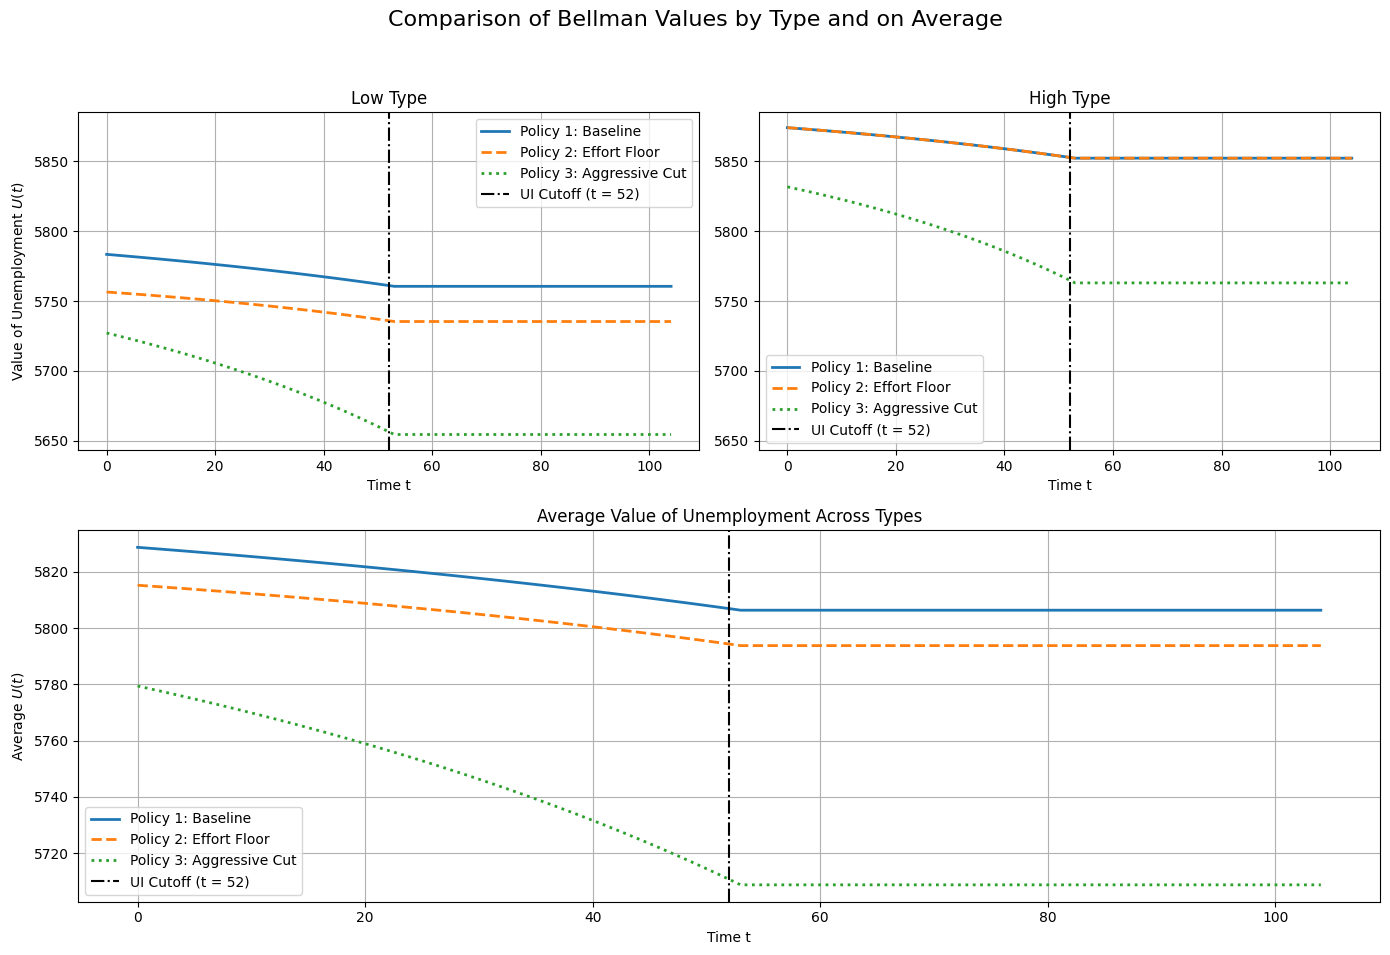

In [ ]:
# --- Calculate average Bellman values across types ---
U_avg_no_floor = 0.5 * (U_path_low[:-1] + U_path_high[:-1])
U_avg_floor = 0.5 * (U_path_low_floor[:-1] + U_path_high_floor[:-1])
U_avg_agg = 0.5 * (U_path_low_agg[:-1] + U_path_high_agg[:-1])


import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.1])  # Slightly larger bottom row

# --- Subplot 1: Low type ---
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(U_path_low[:-1], label="Policy 1: Baseline", linewidth=2)
ax1.plot(U_path_low_floor[:-1], label="Policy 2: Effort Floor", linestyle='--', linewidth=2)
ax1.plot(U_path_low_agg[:-1], label="Policy 3: Aggressive Cut", linestyle=':', linewidth=2)
ax1.axvline(UI_duration, color='black', linestyle='-.', label=f"UI Cutoff (t = {int(UI_duration)})")
ax1.set_title("Low Type")
ax1.set_ylabel("Value of Unemployment $U(t)$")
ax1.set_xlabel("Time t")
ax1.legend()
ax1.grid(True)

# --- Subplot 2: High type ---
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.plot(U_path_high[:-1], label="Policy 1: Baseline", linewidth=2)
ax2.plot(U_path_high_floor[:-1], label="Policy 2: Effort Floor", linestyle='--', linewidth=2)
ax2.plot(U_path_high_agg[:-1], label="Policy 3: Aggressive Cut", linestyle=':', linewidth=2)
ax2.axvline(UI_duration, color='black', linestyle='-.', label=f"UI Cutoff (t = {int(UI_duration)})")
ax2.set_title("High Type")
ax2.set_xlabel("Time t")
ax2.legend()
ax2.grid(True)

# --- Subplot 3: Average ---
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(U_avg_no_floor, label="Policy 1: Baseline", linewidth=2)
ax3.plot(U_avg_floor, label="Policy 2: Effort Floor", linestyle='--', linewidth=2)
ax3.plot(U_avg_agg, label="Policy 3: Aggressive Cut", linestyle=':', linewidth=2)
ax3.axvline(UI_duration, color='black', linestyle='-.', label=f"UI Cutoff (t = {int(UI_duration)})")
ax3.set_title("Average Value of Unemployment Across Types")
ax3.set_xlabel("Time t")
ax3.set_ylabel("Average $U(t)$")
ax3.legend()
ax3.grid(True)

fig.suptitle("Comparison of Bellman Values by Type and on Average", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("bellman_combined_layout.png", dpi=300)
plt.show()
